In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
# Create a session
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"The most recent date in the data set is: {most_recent_date[0]}")


The most recent date in the data set is: 2017-08-23


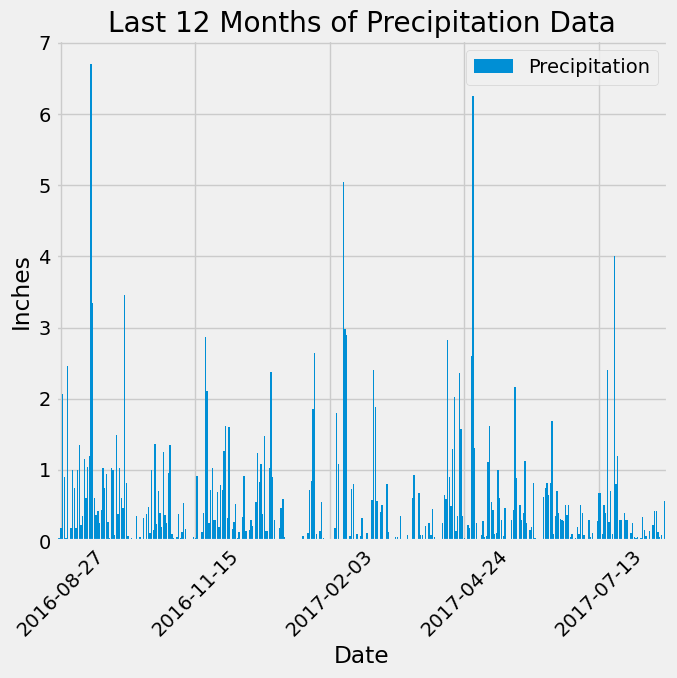

In [10]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# Design a query to retrieve the last 12 months of precipitation data
# Calculate the date one year from the last date in the data set
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(7, 7))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Last 12 Months of Precipitation Data')
plt.xticks(rotation=45)

# Set the x-axis to display only 5 dates
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# Format x-axis to show date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set x-axis limit to start at X,0
plt.xlim(precipitation_df['Date'].min(), precipitation_df['Date'].max())

plt.legend()
plt.tight_layout()
plt.show()



In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()

summary_df = pd.DataFrame(summary_statistics).rename(columns={'Precipitation': 'Precipitation'})

summary_df


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f'Total number of stations: {total_stations}')


Total number of stations: 9


In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Display the results
for station, count in most_active_stations:
    print(f'Station ID: {station}, Number of Rows: {count}')



Station ID: USC00519281, Number of Rows: 2772
Station ID: USC00519397, Number of Rows: 2724
Station ID: USC00513117, Number of Rows: 2709
Station ID: USC00519523, Number of Rows: 2669
Station ID: USC00516128, Number of Rows: 2612
Station ID: USC00514830, Number of Rows: 2202
Station ID: USC00511918, Number of Rows: 1979
Station ID: USC00517948, Number of Rows: 1372
Station ID: USC00518838, Number of Rows: 511


In [30]:
# Using the most active station id from the previous query
most_active_station = most_active_stations[0][0]

# Design a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# Display the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f'Most Active Station ID: {most_active_station}')
print(f'Lowest Temperature: {lowest_temp} °F')
print(f'Highest Temperature: {highest_temp} °F')
print(f'Average Temperature: {avg_temp:.2f} °F')


Most Active Station ID: USC00519281
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


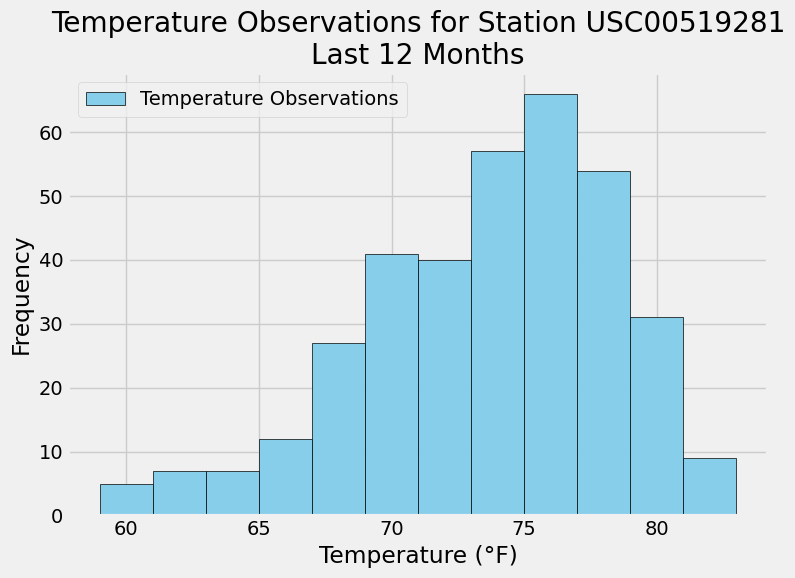

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date one year from the last date in the data set for the most active station
last_date_most_active = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station).scalar()
one_year_ago_most_active = dt.datetime.strptime(last_date_most_active, '%Y-%m-%d') - dt.timedelta(days=365)

# Query the temperature observation data for the last 12 months for the most active station
temperature_data_most_active = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station, Measurement.date >= one_year_ago_most_active).all()

# Convert the results to a Pandas DataFrame
temperature_df_most_active = pd.DataFrame(temperature_data_most_active, columns=['Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df_most_active['Temperature'], bins=12, label='Temperature Observations', color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station}\nLast 12 Months')
plt.legend()
plt.tight_layout()
plt.show()



# Close Session

In [16]:
# Close Session
session.close()